# Beijing Air Quality Regression

Predict a continuous air quality variable (e.g., PM2.5) using weather and time features.

## Colab quick start
1. Upload your Beijing air quality CSV file (e.g., `Beijing Air Quality from 2010 to 2017.csv`).
2. Set the correct file path in the code below.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

sns.set_theme(style='whitegrid')


###  Explanation: Library Imports
- **NumPy & Pandas**: Core libraries for numerical operations and data manipulation
- **Matplotlib & Seaborn**: Visualization libraries for creating plots and heatmaps
- **Scikit-learn modules**:
  - `train_test_split`: Splits data into training and testing sets
  - `StandardScaler`: Normalizes features to mean=0, std=1
  - `OneHotEncoder`: Converts categorical variables to binary columns
  - `SimpleImputer`: Fills missing values
  - `Pipeline` & `ColumnTransformer`: Chains preprocessing steps
  - Regression models: LinearRegression, Ridge, Lasso, DecisionTree, RandomForest, KNN
  - Metrics: MSE, MAE, R² for model evaluation
- `sns.set_theme(style='whitegrid')`: Applies a clean visual style to all plots

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Set your file path here
CSV_PATH = '/content/drive/MyDrive/aayushsir assignment/Beijing Air Quality from 2010 to 2017.csv'

# Load dataset
df = pd.read_csv(CSV_PATH)

# Quick inspection
print(df.head())
print(df.info())


Mounted at /content/drive
      City Country                  Date  Season  \
0  Beijing   China  3/1/2013 12:00:00 AM  Winter   
1  Beijing   China   3/1/2013 1:00:00 AM  Winter   
2  Beijing   China   3/1/2013 2:00:00 AM  Winter   
3  Beijing   China   3/1/2013 3:00:00 AM  Winter   
4  Beijing   China   3/1/2013 4:00:00 AM  Winter   

   PM2.5 concentration (ug/m^3)  PM_Station 3  Dew Point (Fahrenheit)  \
0                           9.0           NaN                   -2.20   
1                          11.0           NaN                   -2.74   
2                           8.0           NaN                   -3.46   
3                           8.0           NaN                   -5.62   
4                           8.0           NaN                   -7.06   

   Temperature (Fahrenheit)  PM2.5  PM10 concentration (ug/m^3)  ...  \
0                      32.0    9.0                          9.0  ...   
1                      32.0   11.0                         11.0  ...   
2     

###  Explanation: Data Loading
- **Google Drive Mount**: Connects to Google Drive to access the CSV file stored there
- **pd.read_csv()**: Loads the Beijing Air Quality dataset into a DataFrame
- **df.head()**: Displays first 5 rows to preview the data structure and column names
- **df.info()**: Shows column data types, non-null counts, and memory usage - helps identify missing values and data type issues

## 1) Clean Data and Set Target

In [ ]:
TARGET_COL = 'PM2.5'

# Drop rows where target is missing
df_clean = df.dropna(subset=[TARGET_COL]).copy()

# Remove duplicate or derived columns to avoid leakage
cols_to_drop = [
    'PM2.5 concentration (ug/m^3)',
    'Temperature (Fahrenheit)',             # Keep only Celsius
    'Dew Point (Fahrenheit)'                # Keep only Celsius
]
for col in cols_to_drop:
    if col in df_clean.columns:
        df_clean = df_clean.drop(columns=col)

# Select features
feature_cols = [col for col in df_clean.columns if col != TARGET_COL and col.lower() != 'date']
X = df_clean[feature_cols]
y = df_clean[TARGET_COL].astype(float)

# Train/test split
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("X_train shape:", X_train_raw.shape)
print("X_test shape :", X_test_raw.shape)


X_train shape: (329478, 20)
X_test shape : (82370, 20)


### 📝 Explanation: Data Cleaning & Train-Test Split
- **Target Variable (PM2.5)**: The continuous variable we want to predict - represents particulate matter concentration in µg/m³
- **dropna(subset=[TARGET_COL])**: Removes rows where PM2.5 is missing (can't train on missing targets)
- **Dropped columns**: Removes redundant features (Fahrenheit temperatures) to avoid multicollinearity - keeps only Celsius versions
- **Feature selection**: All columns except the target and date are used as predictors
- **train_test_split (80/20)**: 80% data for training, 20% for testing; `random_state=42` ensures reproducibility
- **Output**: Shows the dimensions of training and test sets

## 2) Preprocessing Pipeline

**Target variable:** PM2.5 (change as needed)

In [ ]:
# Identify numeric & categorical columns
numeric_features = X_train_raw.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train_raw.select_dtypes(include=['object']).columns

# Pipelines
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# ColumnTransformer
preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, numeric_features),
    ('cat', categorical_pipeline, categorical_features)
])

# Fit & transform
X_train_processed = preprocessor.fit_transform(X_train_raw)
X_test_processed = preprocessor.transform(X_test_raw)

# Feature names
num_features = numeric_features.tolist()
cat_features = preprocessor.named_transformers_['cat'].named_steps['encoder'].get_feature_names_out(categorical_features).tolist()
feature_names = num_features + cat_features

print("Processed X_train shape:", X_train_processed.shape)
print("Processed X_test shape :", X_test_processed.shape)


/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['PM_Station 3' 'Humidity (%)' 'Precipitation (mm, Cumulated)'
 'PM_Station 1' 'PM_US Post' 'PM_Station 2']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


Processed X_train shape: (329478, 29)
Processed X_test shape : (82370, 29)


/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['PM_Station 3' 'Humidity (%)' 'Precipitation (mm, Cumulated)'
 'PM_Station 1' 'PM_US Post' 'PM_Station 2']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


###  Explanation: Preprocessing Pipeline
- **Numeric Pipeline**:
  - `SimpleImputer(strategy='mean')`: Fills missing numeric values with column mean
  - `StandardScaler()`: Normalizes features to mean=0, std=1 (essential for KNN, Ridge, Lasso)
- **Categorical Pipeline**:
  - `SimpleImputer(strategy='most_frequent')`: Fills missing values with the most common category
  - `OneHotEncoder`: Converts categorical variables into binary (0/1) columns
- **ColumnTransformer**: Automatically applies the correct pipeline to each column type
- **fit_transform vs transform**: Fit on training data only, then transform both sets to prevent data leakage
- **Output**: Processed feature dimensions (more columns due to one-hot encoding of categorical features)

## 3) EDA

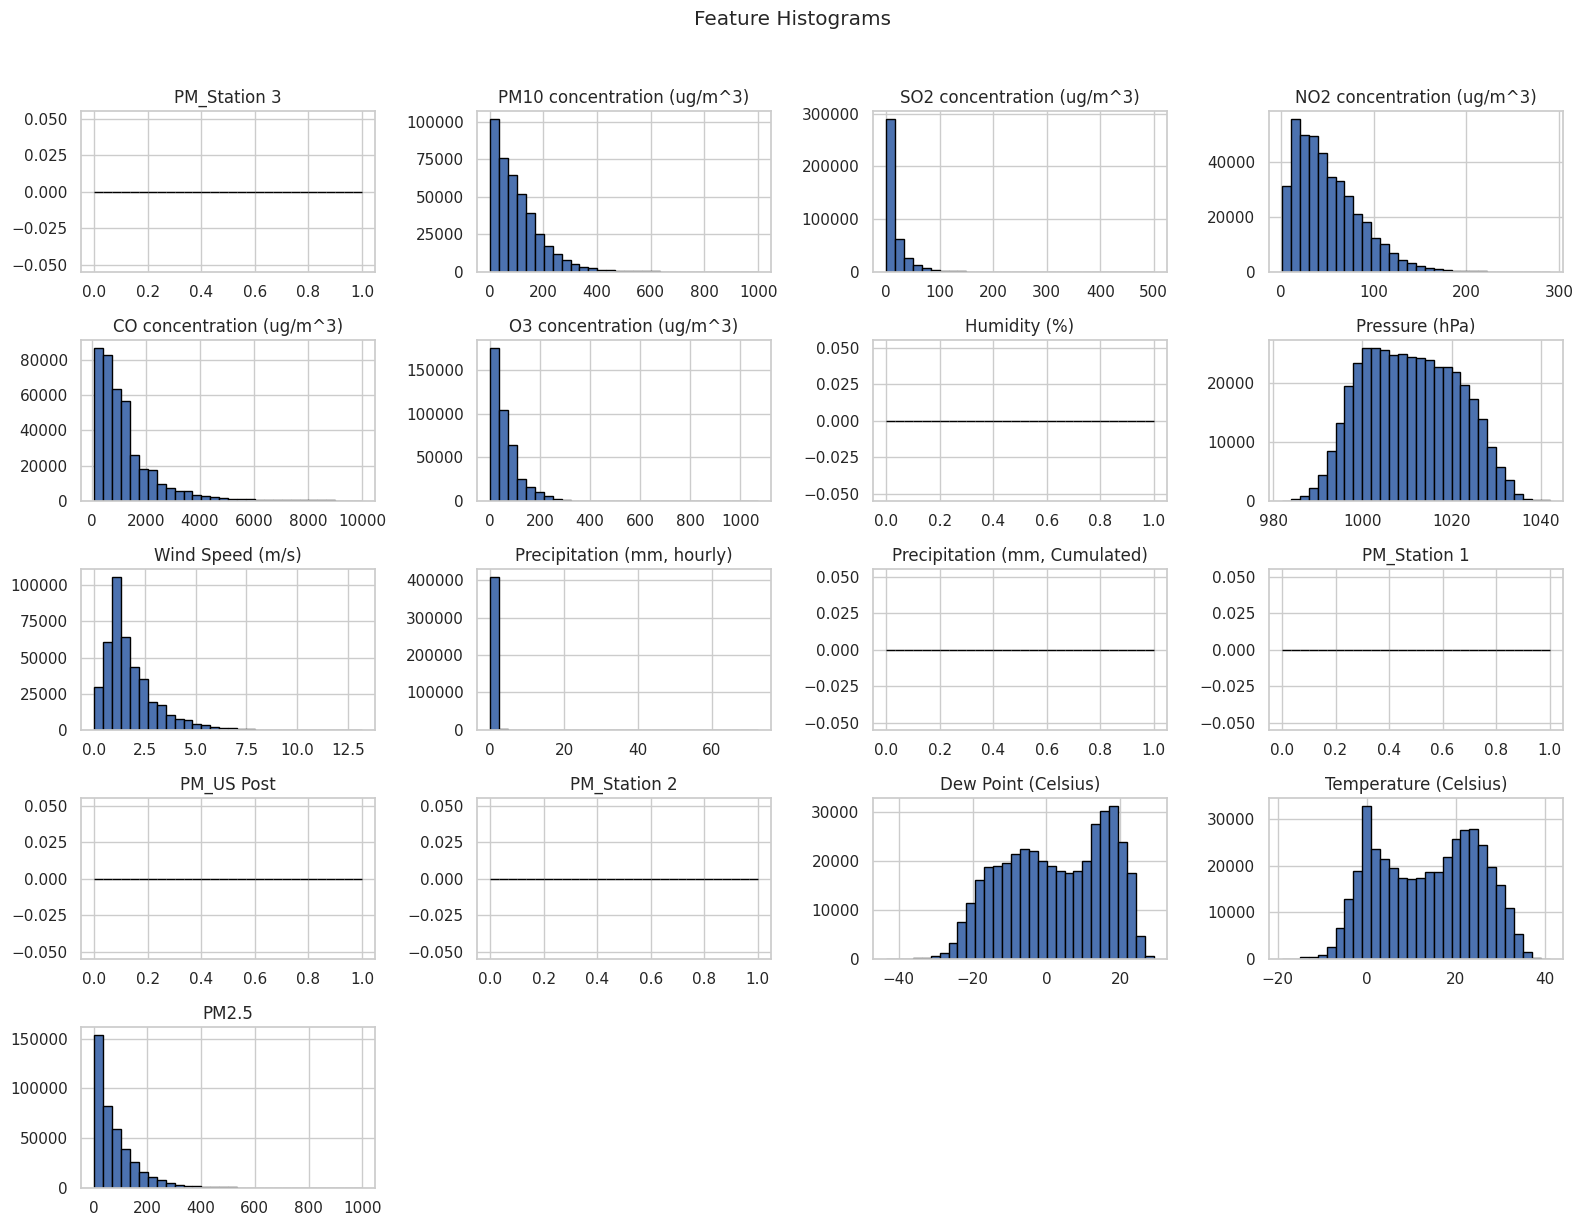

In [ ]:
# Histograms
df_clean[feature_cols + [TARGET_COL]].hist(bins=30, figsize=(16,12), edgecolor='black')
plt.suptitle('Feature Histograms', y=1.02)
plt.tight_layout()
plt.show()




###  Explanation: Feature Histograms
- **Purpose**: Visualize the distribution of each feature and the target variable
- **What to look for**:
  - **Skewness**: Right-skewed (long tail to right) or left-skewed distributions
  - **Outliers**: Extreme values far from the main distribution
  - **Normality**: Whether features follow a bell curve
- **PM2.5 distribution**: Likely right-skewed (many low values, fewer extreme pollution days)
- **Why it matters**: Helps decide if transformations (like log) are needed for better model performance

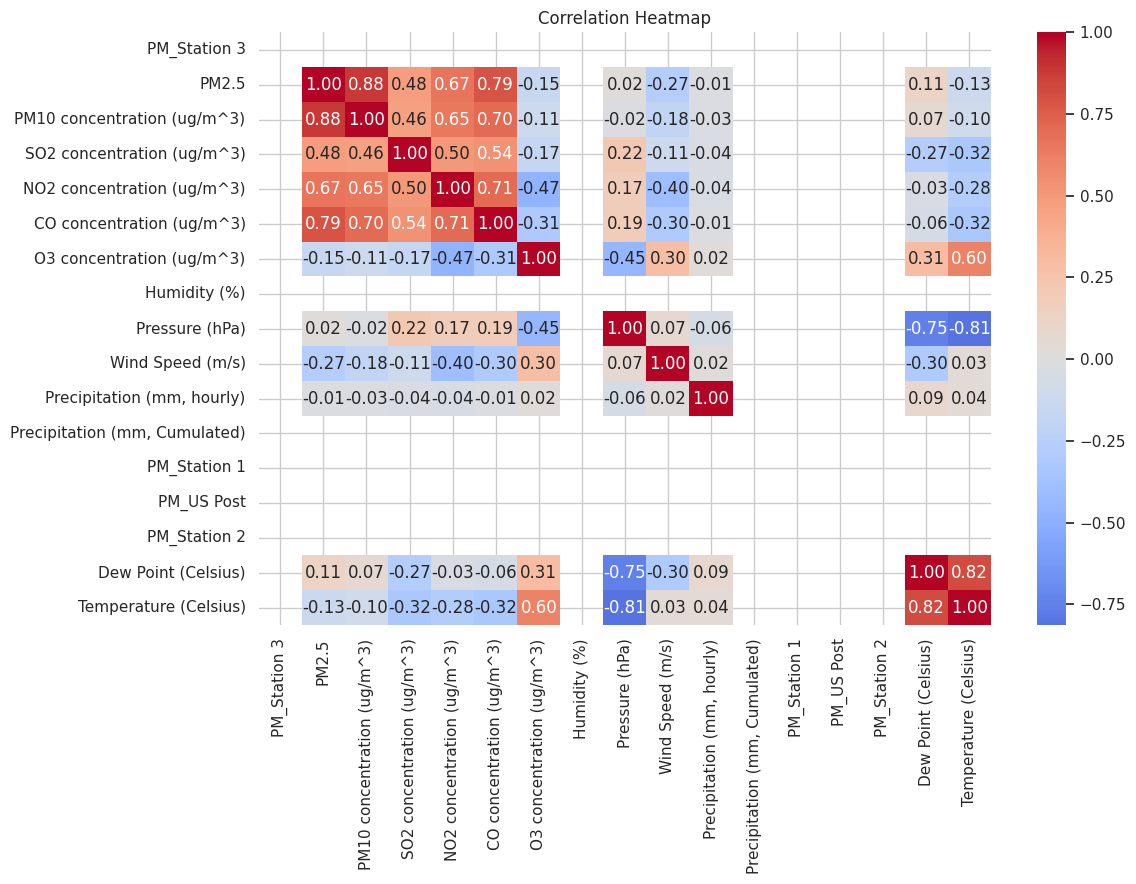

In [ ]:
# Correlation heatmap (numeric only)
plt.figure(figsize=(12,9))
numeric_cols = df_clean.select_dtypes(include=['float64', 'int64']).columns.tolist()
corr = df_clean[numeric_cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

###  Explanation: Correlation Heatmap ✅
- **Purpose**: Shows linear relationships between all numeric variables
- **Interpretation**:
  - **+1 (dark red)**: Perfect positive correlation (both increase together)
  - **-1 (dark blue)**: Perfect negative correlation (one increases, other decreases)
  - **0 (white)**: No linear relationship
  - **Diagonal = 1.0**: Each variable perfectly correlates with itself
- **Key insights to look for**:
  - High correlation with PM2.5 = good predictors
  - High correlation between features = potential multicollinearity (may need to remove one)
- **Code is correct**: Uses Pearson correlation, diverging colormap centered at 0, proper annotations

## 4) Regression Evaluation Function

In [ ]:
def evaluate_regression(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f'\n=== {model_name} ===')
    print(f'MSE  : {mse:.4f}')
    print(f'RMSE : {rmse:.4f}')
    print(f'MAE  : {mae:.4f}')
    print(f'R²   : {r2:.4f}')
    return {'Model': model_name, 'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R2': r2}

results = []


###  Explanation: Evaluation Function
- **MSE (Mean Squared Error)**: Average of squared errors - penalizes large errors more heavily
- **RMSE (Root MSE)**: Square root of MSE - same units as target (µg/m³), easier to interpret
- **MAE (Mean Absolute Error)**: Average absolute difference - robust to outliers
- **R² (R-squared)**: Proportion of variance explained by the model (0 to 1, higher is better)
  - R² = 1: Perfect predictions
  - R² = 0: Model is as good as predicting the mean
  - R² < 0: Model is worse than predicting the mean
- **results list**: Stores metrics from each model for later comparison

## 5) Train Models and Evaluate

In [ ]:
# Linear Regression
lr = LinearRegression()
lr.fit(X_train_processed, y_train)
y_pred_lr = lr.predict(X_test_processed)
results.append(evaluate_regression(y_test, y_pred_lr, 'Linear Regression'))

# Ridge Regression
ridge = Ridge(alpha=1.0, random_state=42)
ridge.fit(X_train_processed, y_train)
y_pred_ridge = ridge.predict(X_test_processed)
results.append(evaluate_regression(y_test, y_pred_ridge, 'Ridge Regression'))

# Lasso Regression
lasso = Lasso(alpha=0.01, random_state=42)
lasso.fit(X_train_processed, y_train)
y_pred_lasso = lasso.predict(X_test_processed)
results.append(evaluate_regression(y_test, y_pred_lasso, 'Lasso Regression'))

# KNN
knn_reg = KNeighborsRegressor(n_neighbors=5)
knn_reg.fit(X_train_processed, y_train)
y_pred_knn = knn_reg.predict(X_test_processed)
results.append(evaluate_regression(y_test, y_pred_knn, 'K-Nearest Neighbors'))

# Decision Tree
dt_reg = DecisionTreeRegressor(random_state=42, max_depth=10)
dt_reg.fit(X_train_processed, y_train)
y_pred_dt = dt_reg.predict(X_test_processed)
results.append(evaluate_regression(y_test, y_pred_dt, 'Decision Tree'))

# Random Forest
rf_reg = RandomForestRegressor(random_state=42, n_estimators=200)
rf_reg.fit(X_train_processed, y_train)
y_pred_rf = rf_reg.predict(X_test_processed)
results.append(evaluate_regression(y_test, y_pred_rf, 'Random Forest'))



=== Linear Regression ===
MSE  : 991.0919
RMSE : 31.4816
MAE  : 20.5606
R²   : 0.8493

=== Ridge Regression ===
MSE  : 991.0921
RMSE : 31.4816
MAE  : 20.5606
R²   : 0.8493

=== Lasso Regression ===
MSE  : 991.1961
RMSE : 31.4833
MAE  : 20.5534
R²   : 0.8493

=== K-Nearest Neighbors ===
MSE  : 527.2931
RMSE : 22.9629
MAE  : 14.2545
R²   : 0.9198

=== Decision Tree ===
MSE  : 630.3081
RMSE : 25.1059
MAE  : 15.7554
R²   : 0.9042

=== Random Forest ===
MSE  : 400.8082
RMSE : 20.0202
MAE  : 12.2480
R²   : 0.9391


### Explanation: Model Training Results
| Model | Description |
|-------|-------------|
| **Linear Regression** | Simple baseline assuming linear relationships between features and target |
| **Ridge Regression** | Linear + L2 regularization (α=1.0) - shrinks coefficients to prevent overfitting |
| **Lasso Regression** | Linear + L1 regularization (α=0.01) - can zero out irrelevant features (feature selection) |
| **K-Nearest Neighbors** | Predicts based on average of 5 nearest neighbors - captures local patterns |
| **Decision Tree** | Tree-based model (max_depth=10) - captures non-linear relationships, depth limit prevents overfitting |
| **Random Forest** | Ensemble of 200 decision trees - usually best performer, reduces variance through averaging |

- Each model is trained on preprocessed training data and evaluated on the test set
- Results are stored for comparison

## 6) Model Comparison

In [ ]:
comparison_df = pd.DataFrame(results)
comparison_df = comparison_df.sort_values('R2', ascending=False)
print("\n=== Model Comparison ===")
print(comparison_df)



=== Model Comparison ===
                 Model         MSE       RMSE        MAE        R2
5        Random Forest  400.808180  20.020194  12.247974  0.939075
3  K-Nearest Neighbors  527.293074  22.962863  14.254530  0.919849
4        Decision Tree  630.308123  25.105938  15.755351  0.904190
0    Linear Regression  991.091885  31.481612  20.560566  0.849349
1     Ridge Regression  991.092101  31.481615  20.560557  0.849349
2     Lasso Regression  991.196130  31.483267  20.553360  0.849333


###  Explanation: Model Comparison
- **Comparison DataFrame**: Consolidates all model metrics in one table
- **Sorted by R²**: Best performing model appears at the top
- **Expected results**:
  - Random Forest typically has highest R² (handles non-linear relationships well)
  - Linear models (Linear, Ridge, Lasso) perform similarly if relationship is mostly linear
  - Decision Tree may overfit or underfit compared to Random Forest
- **Best model selection**: Choose the model with highest R² and lowest RMSE/MAE for deployment

7) Visualization (Random Forest: Actual vs Predicted)

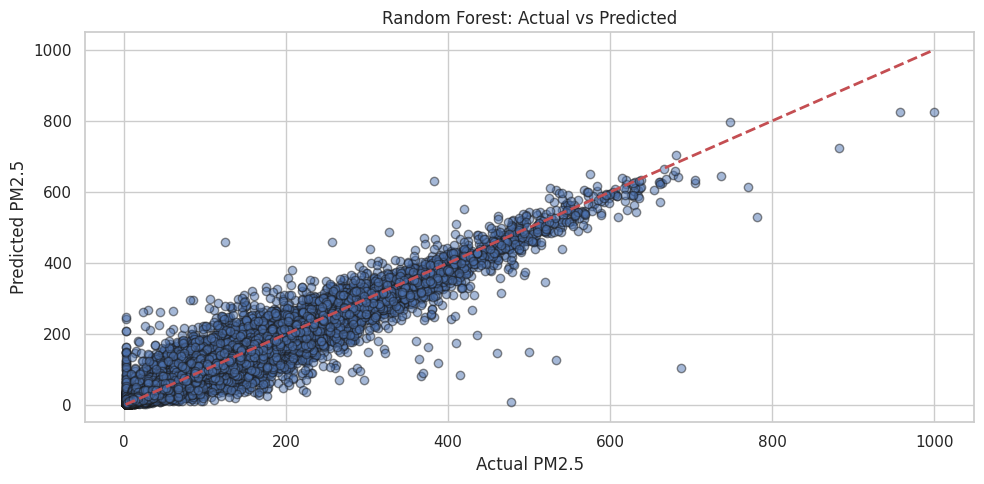

In [ ]:
plt.figure(figsize=(10,5))
plt.scatter(y_test, y_pred_rf, alpha=0.5, edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual PM2.5')
plt.ylabel('Predicted PM2.5')
plt.title('Random Forest: Actual vs Predicted')
plt.tight_layout()
plt.show()


###  Explanation: Actual vs Predicted Plot
- **Scatter plot**: Each point represents a test sample (X = actual PM2.5, Y = predicted PM2.5)
- **Red dashed line**: Perfect prediction line (y = x) - points on this line are perfect predictions
- **Interpretation**:
  - Points close to red line = accurate predictions
  - Points above line = model over-predicted
  - Points below line = model under-predicted
  - Tight clustering around line = good model fit
  - Wide scatter = high prediction error
- **alpha=0.5**: Transparency helps visualize overlapping points
- This visualization helps identify if the model struggles with certain ranges (e.g., extreme values)